<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/generate_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json,pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import load_model,Model
from PIL import Image 
from tqdm import tqdm
import pickle

In [ ]:
image_model = VGG16(include_top=True,weights='imagenet')
image_model.summary()

553467904/553467096 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
transfer_layer = image_model.get_layer('block5_conv3')
encoder_model = Model(inputs=image_model.input,outputs=transfer_layer.output)
value_size = K.int_shape(transfer_layer.output)[1]

In [ ]:
# Provide by @snsd0805
def preprocess_img(path):
  img = image.load_img(path, target_size=(224, 224))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features = encoder_model.predict(x)
  return features

In [ ]:
max_length = 30
start = '<sos>'
end = '<end>'

# val_voc_5.pkl
* 內容包含: word_index 跟 inv_word_index
* 檔名的 5 代表取整個 annotation 的詞中出現次數超過 5 的詞彙
* 根據 model 使用的資料可能會需要不同的 voc

In [ ]:
voc_path = open('/content/drive/MyDrive/MSCOCO_2017/train_voc_5_unk.pkl','rb') # 根據model用的data，需更換VOC
voc_data = pickle.load(voc_path)
word_index = voc_data['word_index']
inv_word_index = voc_data['inv_word_index']
voc_size = len(word_index) + 1
# 在這裡更改你要用的 model 檔案位置
model_path = '/content/drive/MyDrive/MSCOCO_2017/model_noatt_train5000data_1.h5'
decoder_model = load_model(model_path)

In [ ]:
#如果要用pretrain好的encoder output，img_data要給，img_path用空字串
#如果要預測單一圖片 給img_path就好，img_data用空list
def generate_caption(decoder_model,img_path,img_data,show=True):
  if img_data == []:
    img_data = preprocess_img(img_path)
  decoder_input = np.zeros((1,max_length),dtype='float32')
  token_cur = word_index[start]
  output_text = ''
  count_tokens = 0
  while token_cur != word_index[end] and count_tokens < max_length:
    decoder_input[0,count_tokens] = token_cur
    decoder_output = decoder_model.predict([img_data,decoder_input])
    token_cur = np.argmax(decoder_output[0,count_tokens]) 
    cur_word = inv_word_index[token_cur]
    if(cur_word != end):
      output_text += " " + cur_word
    count_tokens += 1
  if show:
    test_image = plt.imread(img_path)
    plt.imshow(test_image)
    plt.show()
    print("Caption:")
    print(output_text)
    return output_text
  else:
    return output_text

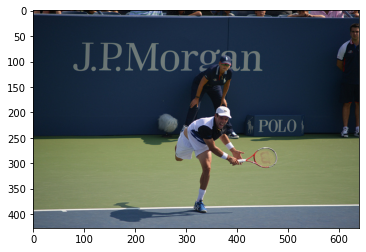

Caption:
 a tennis player is swinging a racket at a ball <unk>


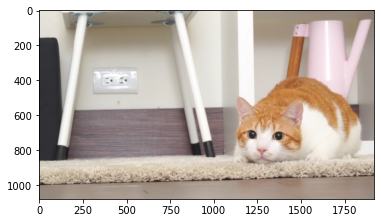

Caption:
 a cat sitting on a wooden floor next to a remote control <unk>


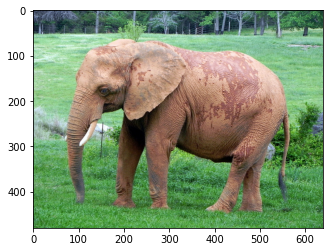

Caption:
 a group of elephants standing in a field with other animals <unk>


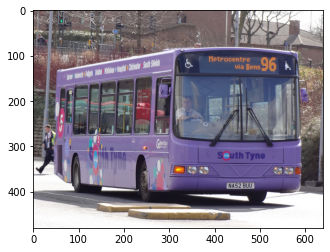

Caption:
 a bus parked in front of a building <unk>


' a bus parked in front of a building <unk>'

In [ ]:
# 上方的所有code都要跑過
# 在上方更改你要用的 model 檔案位置跟你要 caption 的檔案位置就可以用了

generate_caption(decoder_model,'/content/drive/MyDrive/MSCOCO_2017/val2017/000000000885.jpg',[])
generate_caption(decoder_model,'/content/drive/MyDrive/eggroll.jpg',[])
# generate_caption(decoder_model,'/content/drive/MyDrive/me.jpg',[])
generate_caption(decoder_model,'/content/drive/MyDrive/MSCOCO_2017/test2017/000000001371.jpg',[])
generate_caption(decoder_model,'/content/drive/MyDrive/MSCOCO_2017/val2017/000000002006.jpg',[])

# 用來算 BLEU 的 code

In [ ]:
p = open('/content/drive/MyDrive/MSCOCO_2017/new-dataset/output_14x14x512_5000_val.pkl','rb')
val_data = pickle.load(p)

In [ ]:
val_data[0]

In [ ]:
#用file_name反推image_id
def get_imgid(file_name):
  id = ""
  f = 0
  for i in range(12):
    if file_name[i] != "0":
      f = 1
    if f == 1: 
      id += file_name[i]
  return int(id)

In [ ]:
get_imgid('000000700765.jpg')

'700765'

In [ ]:
# 產生所有 val 的 caption 預測結果並輸出成規定格式
# 評分資料格式在 https://cocodataset.org/#format-data 的 5. Image Captioning 大標下有規定
results = list()
for data in tqdm(val_data):  # 多加個 tqdm 是為了看他印出漂亮的進度條
  one_result = dict()
  cap = generate_caption(decoder_model,"",data['feature'],show=False) # 把這裡替換成你用來生 caption 的 function
  one_result["image_id"] = get_imgid(data['filename'])
  one_result["caption"] = cap
  results.append(one_result)

In [ ]:
# 輸出成 json 檔
model_name = os.path.basename(model_path)
save_path = "/content/drive/MyDrive/MSCOCO_2017/score/"
generated_json_path = save_path +"generated_"+ model_name +".json"
print("json saved at", generated_json_path)
with open(generated_json_path, 'w') as jsonfile:
  json.dump(results, jsonfile)

In [ ]:
import os, sys
if not os.path.exists('coco-caption'):
  # 下載相容 Python3 的非官方套件
  !git clone https://github.com/davidfsemedo/coco-caption
sys.path.insert(0,"/content/coco-caption")
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')


In [ ]:
def evaluate_coco(generated_json, answer_json):
  # 繞過 val2017 和 2014 格式不同的 bug 
  # https://github.com/tylin/coco-caption/issues/26#issuecomment-439825144
  if (os.path.basename(answer_json) == "captions_val2017.json"):
    modified_anno_path = "/content/modified_captions_val2017.json"
    with open(answer_json, 'r') as f:
      data = json.load(f)
    data['type'] = 'captions'
    with open(modified_anno_path, 'w') as f:
      json.dump(data, f)
    answer_anno_path = modified_anno_path
  else:
    answer_anno_path = answer_json

  coco = COCO(answer_anno_path)
  cocoRes = coco.loadRes(generated_json)

  # create cocoEval object by taking coco and cocoRes
  cocoEval = COCOEvalCap(coco, cocoRes)

  # evaluate on a subset of images by setting
  # cocoEval.params['image_id'] = cocoRes.getImgIds()
  # please remove this line when evaluating the full validation set
  cocoEval.params['image_id'] = cocoRes.getImgIds()

  # evaluate results
  cocoEval.evaluate()
    
  return cocoEval

In [ ]:
answer_json_path = "/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json"
cocoEval = evaluate_coco(generated_json_path, answer_json_path)

In [ ]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
  print('%s: %.3f'%(metric, score))

In [ ]:
# 評分結果自動彙整進 csv 檔
import csv

scoredict = {'model_name': model_name,
             'train_data': '14x14x512', # '7x7x512' or '14x14x512' or '4096'
             'voc': 'train_voc_5_unk', # 'train_voc_5' or 'train_voc_5_unk'
             'oov_vector': 'random', # 'zero' or 'random'
             'unk_token': 'average', # 'average' or 'none'
             'train_epoch': 92, # 若有 earlystop，填實際上停在第幾 epoch
             'TimeDistributed_dropout': 0.5,
             'recurrent_dropout': 0,
             'predict_data_num': 2500}

fieldnames = ['model_name', 'train_data', 'voc', 'oov_vector', 'unk_token', 
              'train_epoch', 'TimeDistributed_dropout','recurrent_dropout','predict_data_num']
for metric, score in cocoEval.eval.items():
  fieldnames.append(metric)
  scoredict[metric] = score 
  # 還會多存 ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr']
  # 的 column 和分數

score_save_path = save_path + 'integrate_score.csv'
with open(score_save_path, 'a', newline='') as csvfile:
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  # writer.writeheader() # 創新檔的時候再跑
  writer.writerow(scoredict)
  csvfile.close()